In [1592]:
#We're in EXERCISE 3

In [1593]:
'''pip install pandas
pip install matplotlib
pip install numpy'''

'pip install pandas\npip install matplotlib\npip install numpy'

In [1594]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.optimize as sco

# Import datatsets

In [1595]:
#Monthly RI and capitalization of EUR firms
df_EUR_M_cap=pd.read_csv('https://raw.githubusercontent.com/GiammarcoBozzelli/SEF/ex_2/df_EUR_monthly_capitalization.csv')
df_EUR_M_RI=pd.read_csv('https://raw.githubusercontent.com/GiammarcoBozzelli/SEF/ex_2/df_EUR_monthly_RI.csv')
#Yearly RI and capitalization of EUR firms
df_EUR_Y_cap=pd.read_csv('https://raw.githubusercontent.com/GiammarcoBozzelli/SEF/baltha/df_EUR_yearly_capitalization.csv')
df_EUR_Y_RI=pd.read_csv('https://raw.githubusercontent.com/GiammarcoBozzelli/SEF/baltha/df_EUR_yearly_return.csv')
#Yearly E score 
df_E_score=pd.read_csv('https://raw.githubusercontent.com/GiammarcoBozzelli/SEF/baltha/DS_EScore_Y.csv')

# Question 3

### Create the dataset 

In [1596]:
#Create a new column with only the 2 first caracters of the column ISIN

df_E_score['ISIN_First2'] = df_E_score['ISIN'].str[:2]

In [1597]:
#df_E_score

In [1598]:
#Compute the monthly returns of EUR firms
df_EUR_M_RI.set_index('NAME', inplace = True)

df_EUR_M_RI.drop(df_EUR_M_RI.columns[:4], axis=1, inplace=True)

df_EUR_M_RI.columns = pd.to_datetime(df_EUR_M_RI.columns)

#df_EUR_M_RI_08 = df_EUR_M_RI.loc[:, (df_EUR_M_RI.columns >= pd.to_datetime("2007-01-01"))]
df_EUR_M_RI_08 = df_EUR_M_RI.loc[:, ((df_EUR_M_RI.columns >= pd.to_datetime("2007-01-01")) & (df_EUR_M_RI.columns <= ("2021-12-31")))]

df_EUR_M_RI_T = df_EUR_M_RI_08.T

df_M_returns = df_EUR_M_RI_T.pct_change()

#df_M_returns

In [1599]:
#Extract the list of firms that have an Environmental score
firms_list = df_E_score['NAME'].tolist()
#firms_list

In [1600]:
#Get monthly returns of EUR firms with an Environmental score
df_M_returns_E = df_M_returns[df_M_returns.columns.intersection(firms_list)]
#df_M_returns_E


In [1601]:
#Drop the row 2007-01-31 because it has only NaN values
df_M_returns_E = df_M_returns_E.drop('2007-01-31')
#df_M_returns_E

### Average/expected return

In [1602]:
#Compute the average (or expected) returns
avrg_returns = df_M_returns_E.mean()
#avrg_returns

In [1603]:
#The company PROFASE probably dropped out of the market; the change in returns would be infinite, we set it to 0
avrg_returns[avrg_returns == np.inf] = 0 

### Covariance matrix

In [1604]:
#Compute the covariance matrix
cov_matrix = df_M_returns_E.cov()
#cov_matrix

### Minimum variance portfolio (MVP)

In [1605]:
#Taking the number of assets
numAssets = len(avrg_returns)

#Function to compute the variance
def min_var(weights):
    weights = np.array(weights)
    var = np.dot(weights.T, np.dot(cov_matrix * 12, weights))
    return var

#Initial conditions: initial weights -> EW and each weight >= 0
initialWeights = np.ones(numAssets)/numAssets
positivity_bounds = tuple((0, 1) for x in range(numAssets))

#Constraint: sum of weights = 1
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})

#Optimize minimum variance portfolio
result_long_only_gmv_portfolio = sco.minimize(min_var, initialWeights, method='SLSQP', bounds=positivity_bounds, constraints=cons)
result_long_only_gmv_portfolio

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.011782738488221834
       x: [ 5.627e-17  9.157e-17 ...  1.209e-17  0.000e+00]
     nit: 16
     jac: [ 4.012e-02  5.912e-02 ...  4.906e-02  4.315e-02]
    nfev: 6784
    njev: 16

In [1606]:
#Compute the minimum variance portfolio
avrg_returns_MVP = np.dot(result_long_only_gmv_portfolio['x'], avrg_returns)
avrg_returns_MVP

0.008174273336268282

In [1607]:
#Compute the annualized MVP
avrg_returns_MVP_ann = avrg_returns_MVP * 12
avrg_returns_MVP_ann

0.09809128003521939

### Maximum return portfolio

In [1608]:
#Function to compute the returns
def max_return(weights):
    weighted_returns = -np.dot(weights, avrg_returns * 12)
    return weighted_returns

#Constraints (same as for the MVP portfolio)
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1}, {'type': 'ineq', 'fun': lambda x: x})
positivity_bounds = tuple((0, 1) for x in range(numAssets))
initialWeights = np.ones(numAssets)/numAssets

#Optimize maximum return portfolio
result_max_return_portfolio = sco.minimize(max_return, initialWeights, method='SLSQP', bounds=positivity_bounds, constraints=cons)
result_max_return_portfolio

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.3285704930020861
       x: [ 1.663e-15  0.000e+00 ...  0.000e+00  1.132e-16]
     nit: 9
     jac: [-9.430e-02 -1.035e-01 ... -7.079e-02 -1.834e-01]
    nfev: 3816
    njev: 9

In [1609]:
#Check the weights of the maximum return portfolio
#result_max_return_portfolio['x']

In [1610]:
#Compute the maximum return portfolio
avrg_returns_MaxRP = np.dot(result_max_return_portfolio['x'], avrg_returns)
avrg_returns_MaxRP

0.027380874416840503

In [1611]:
#Compute the annualized maximum return portfolio
avrg_returns_MaxRP_ann = avrg_returns_MaxRP * 12
avrg_returns_MaxRP_ann

0.328570493002086

### Minimum return portfolio

In [1612]:
#Function to compute the returns
def min_return(weights):
    weight_returns = np.dot(weights, avrg_returns * 12)
    return weight_returns

#Constraints
numAssets = len(avrg_returns)
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
positivity_bounds = tuple((0, 1) for x in range(numAssets))
initialWeights = np.array(numAssets*[1/numAssets])

#Optimize minimum return portfolio
result_min_return_portfolio = sco.minimize(min_return, initialWeights, method='SLSQP', bounds= positivity_bounds, constraints=cons)
result_min_return_portfolio

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.4149087840273254
       x: [ 9.771e-16  0.000e+00 ...  0.000e+00  2.140e-16]
     nit: 6
     jac: [ 9.430e-02  1.035e-01 ...  7.079e-02  1.834e-01]
    nfev: 2544
    njev: 6

In [1613]:
#Compute the minimum return portfolio
avrg_returns_MinRP = np.dot(result_min_return_portfolio['x'], avrg_returns)
avrg_returns_MinRP

-0.03457573200227714

In [1614]:
#Compute the annualized minimum return portfolio
avrg_returns_MinRP_ann = avrg_returns_MinRP * 12
avrg_returns_MinRP_ann

-0.41490878402732567

### Efficient frontier

In [1615]:
#Upper part of the efficient frontier

#Generate an array of evenly spaced target returns between the average return of the MVP and the average return of the max return portfolio
target_returns = np.linspace(avrg_returns_MVP, avrg_returns_MaxRP, 25)

#Initialize an empty list to store all the efficient portfolios to build the efficient frontier, and another for the portfolio weights
efficient_frontier_high = []
portfolio_weights = []

#Define portfolio volatility
def portfolio_volatility(weights):
    return np.sqrt(weights.T @ cov_matrix @ weights)

#Define the return constraint
def return_constraint(weights):
    return (weights @ avrg_returns) - target_return

#Constraints: sum of weights equals 1, portfolio weights * average returns = target return
for target_return in target_returns:
    cons = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': return_constraint})
    
#Run the optimization
    result = sco.minimize(portfolio_volatility, initialWeights, method='SLSQP', bounds=positivity_bounds, constraints=cons)

#Check if optimizer found a solution, if yes add the result (volatility, return)
    if result.success:
        efficient_frontier_high.append((result.fun, target_return))
        portfolio_weights.append(result.x)

#Put the results into a dataframe: it will contain the returns and their minimized volatility
df_frontier_high = pd.DataFrame(efficient_frontier_high, columns=['Volatility', 'Return'])
df_weights_high = pd.DataFrame(portfolio_weights)

In [1616]:
#Lower part of the efficient frontier

#Generate an array of evenly spaced target returns between the average return of the MVP and the average return of the max return portfolio
target_returns = np.linspace(avrg_returns_MVP, avrg_returns_MinRP, 25)

#Initialize an empty list to store all the efficient portfolios to build the efficient frontier, and another for the portfolio weights
efficient_frontier_low = []
portfolio_weights = []

#Define portfolio volatility
def portfolio_volatility(weights):
    return np.sqrt(weights.T @ cov_matrix @ weights)

#Define the return constraint
def return_constraint(weights):
    return (weights @ avrg_returns) - target_return

#Constraints: sum of weights equals 1, portfolio weights * average returns = target return
for target_return in target_returns:
    cons = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': return_constraint})
    
#Run the optimization
    result = sco.minimize(portfolio_volatility, initialWeights, method='SLSQP', bounds=positivity_bounds, constraints=cons)

#Check if optimizer found a solution, if yes add the result (volatility, return)
    if result.success:
        efficient_frontier_low.append((result.fun, target_return))
        portfolio_weights.append(result.x)

#Put the results into a dataframe: it will contain the returns and their minimized volatility
df_frontier_low = pd.DataFrame(efficient_frontier_low, columns=['Volatility', 'Return'])
df_weights_low = pd.DataFrame(portfolio_weights)

In [1617]:
#Concatenate the upper part and lower part of the efficient frontier, same for the weights
df_frontier = pd.concat([df_frontier_high, df_frontier_low]).reset_index(drop=True)
df_weights = pd.concat([df_weights_high, df_weights_low]).reset_index(drop=True)

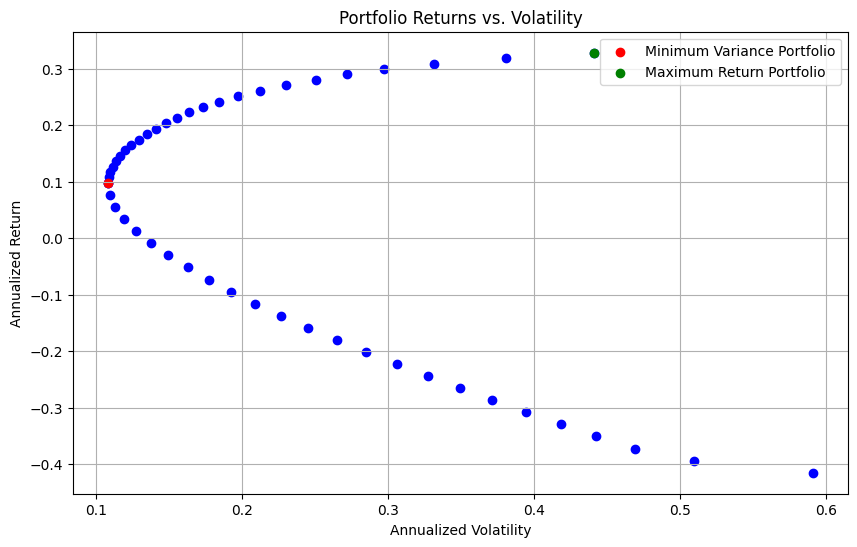

In [1618]:
#Annualize volatility and returns
df_frontier['Annualized Volatility'] = df_frontier['Volatility'] * np.sqrt(12)
df_frontier['Annualized Return'] = df_frontier['Return'] * 12

#Take the index of the MVP and MaxRP
MVP_index = df_frontier['Annualized Volatility'].idxmin()
MaxRP_index = df_frontier['Annualized Return'].idxmax()

#Initialize the figure
plt.figure(figsize=(10, 6))

#Plot the portfolios of the efficient frontier
plt.scatter(df_frontier['Annualized Volatility'], df_frontier['Annualized Return'], color='blue')

#Plot the MVP and the Max return portfolio (MaxRP)
plt.scatter(df_frontier.loc[MVP_index, 'Annualized Volatility'], df_frontier.loc[MVP_index, 'Annualized Return'], color='red', label='Minimum Variance Portfolio')
plt.scatter(df_frontier.loc[MaxRP_index, 'Annualized Volatility'], df_frontier.loc[MaxRP_index, 'Annualized Return'], color='green', label='Maximum Return Portfolio')

#Add title, legends, ect
plt.title('Portfolio Returns vs. Volatility')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.legend()
plt.grid(True)
plt.show()

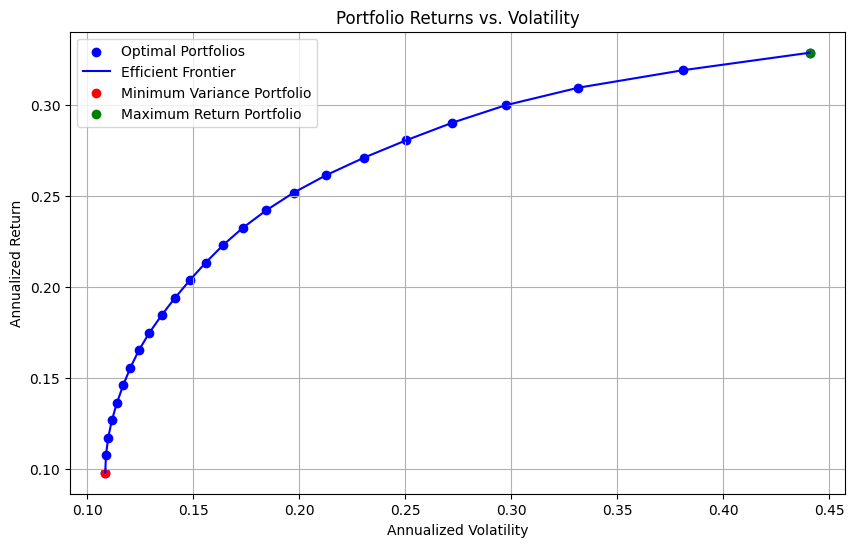

In [1619]:
#Keep only the upper part of the efficient frontier
#Annualize volatility and returns
df_frontier_high['Annualized Volatility'] = df_frontier_high['Volatility'] * np.sqrt(12)
df_frontier_high['Annualized Return'] = df_frontier_high['Return'] * 12

#Take the index of the MVP and MaxRP
MVP_index = df_frontier_high['Annualized Volatility'].idxmin()
MaxRP_index = df_frontier_high['Annualized Return'].idxmax()

#Initialize the figure
plt.figure(figsize=(10, 6))

#Plot the efficient frontier
plt.scatter(df_frontier_high['Annualized Volatility'], df_frontier_high['Annualized Return'], color='blue', label='Optimal Portfolios')
plt.plot(df_frontier_high['Annualized Volatility'], df_frontier_high['Annualized Return'], color='blue', label='Efficient Frontier')

#Plot the MVP and the Max return portfolio (MaxRP)
plt.scatter(df_frontier_high.loc[MVP_index, 'Annualized Volatility'], df_frontier_high.loc[MVP_index, 'Annualized Return'], color='red', label='Minimum Variance Portfolio')
plt.scatter(df_frontier_high.loc[MaxRP_index, 'Annualized Volatility'], df_frontier_high.loc[MaxRP_index, 'Annualized Return'], color='green', label='Maximum Return Portfolio')

#Add title, legends, ect
plt.title('Portfolio Returns vs. Volatility')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.legend()
plt.grid(True)
plt.show()

### Ex-ante

In [1620]:
#Create the risk-free rate
rf = pd.read_csv('https://raw.githubusercontent.com/GiammarcoBozzelli/SEF/FINAL/risk_free_rate_OECD.csv')
rf.head()

#Get the risk-free rate
rfr = rf.OBS_VALUE
rfr21 = rfr[:-1]

#Average annual risk free rate across all european countries over the 2000-2021 period
rfr_expected = rfr21.mean()/100

In [1621]:
rfr_expected

0.029896900272727275

In [1622]:
#Compute the sharpe ratio for each portfolio on the efficient frontier
df_frontier_high['Sharpe Ratio'] = (df_frontier_high['Annualized Return'] - rfr_expected) / df_frontier_high['Annualized Volatility']

#Find the portfolio with the maximum sharpe ratio
max_sharpe_index = df_frontier_high['Sharpe Ratio'].idxmax()
max_sharpe_portfolio = df_frontier_high.loc[max_sharpe_index]
print(max_sharpe_portfolio)

Volatility               0.044996
Return                   0.017778
Annualized Volatility    0.155869
Annualized Return        0.213331
Sharpe Ratio             1.176847
Name: 12, dtype: float64


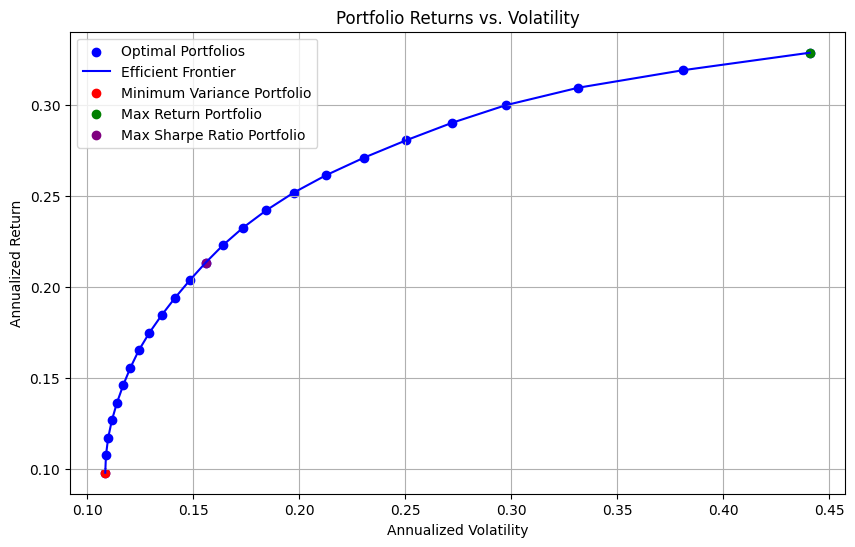

In [1623]:
#Initialize the figure
plt.figure(figsize=(10, 6))

#Plot the efficient frontier
plt.scatter(df_frontier_high['Annualized Volatility'], df_frontier_high['Annualized Return'], color='blue', label='Optimal Portfolios')
plt.plot(df_frontier_high['Annualized Volatility'], df_frontier_high['Annualized Return'], color='blue', label='Efficient Frontier')

#Plot the MVP, the MaxRP, and the Max Sharpe Ratio Portfolio
plt.scatter(df_frontier_high.loc[MVP_index, 'Annualized Volatility'], df_frontier_high.loc[MVP_index, 'Annualized Return'], color='red', label='Minimum Variance Portfolio')
plt.scatter(df_frontier_high.loc[MaxRP_index, 'Annualized Volatility'], df_frontier_high.loc[MaxRP_index, 'Annualized Return'], color='green', label='Max Return Portfolio')
plt.scatter(df_frontier_high.loc[max_sharpe_index, 'Annualized Volatility'], df_frontier_high.loc[max_sharpe_index, 'Annualized Return'], color='purple', label='Max Sharpe Ratio Portfolio')

#Add title, legends, ect
plt.title('Portfolio Returns vs. Volatility')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.legend()
plt.grid(True)
plt.show()

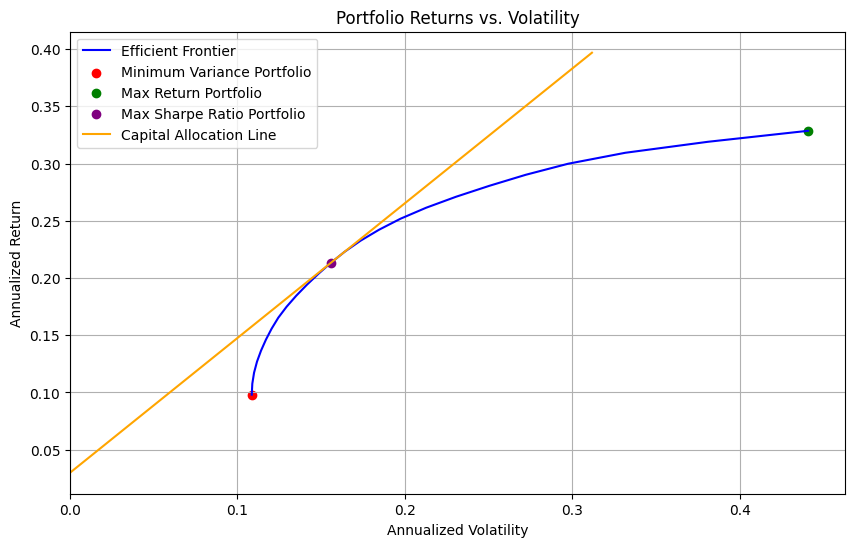

In [1624]:
#Initialize the figure
plt.figure(figsize=(10, 6))

#Get the volatility and the return of the maximum sharpe ratio portfolio
max_sharpe_volatility = df_frontier_high.loc[max_sharpe_index, 'Annualized Volatility']
max_sharpe_return = df_frontier_high.loc[max_sharpe_index, 'Annualized Return']

#Excess return of the Max Sharpe Ratio portfolio over the risk-free rate
max_sharpe_excess_return = max_sharpe_return - rfr_expected

#Get the slope of the capital allocation line (CAL), and the boundaries
CAL_slope = max_sharpe_excess_return / max_sharpe_volatility
CAL_x = max_sharpe_volatility * 2
CAL_y = rfr_expected + (CAL_x * (max_sharpe_return - rfr_expected) / max_sharpe_volatility)

#Plot the efficient frontier
#plt.scatter(df_frontier_high['Annualized Volatility'], df_frontier_high['Annualized Return'], color='blue', label='Optimal Portfolios')
plt.plot(df_frontier_high['Annualized Volatility'], df_frontier_high['Annualized Return'], color='blue', label='Efficient Frontier')

#Plot the MVP, the MaxRP, and the Max Sharpe Ratio Portfolio
plt.scatter(df_frontier_high.loc[MVP_index, 'Annualized Volatility'], df_frontier_high.loc[MVP_index, 'Annualized Return'], color='red', label='Minimum Variance Portfolio')
plt.scatter(df_frontier_high.loc[MaxRP_index, 'Annualized Volatility'], df_frontier_high.loc[MaxRP_index, 'Annualized Return'], color='green', label='Max Return Portfolio')
plt.scatter(df_frontier_high.loc[max_sharpe_index, 'Annualized Volatility'], df_frontier_high.loc[max_sharpe_index, 'Annualized Return'], color='purple', label='Max Sharpe Ratio Portfolio')

#Plot the capital allocation line (CAL)
plt.plot([0, CAL_x], [rfr_expected, CAL_y], color='orange', label='Capital Allocation Line')

#Add title, legends, ect
plt.xlim(0)
plt.title('Portfolio Returns vs. Volatility')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.legend()
plt.grid(True)
plt.show()

In [1625]:
df_frontier_high

,Volatility,Return,Annualized Volatility,Annualized Return,Sharpe Ratio
0,0.031335,0.008174,0.108548,0.098091,0.628239
1,0.031431,0.008975,0.108881,0.107695,0.714519
2,0.031734,0.009775,0.109929,0.117298,0.795069
3,0.032238,0.010575,0.111676,0.126901,0.868623
4,0.032930,0.011375,0.114074,0.136504,0.934549
5,0.033775,0.012176,0.117000,0.146108,0.993258
6,0.034757,0.012976,0.120403,0.155711,1.044943
7,0.035911,0.013776,0.124398,0.165314,1.088582
8,0.037346,0.014576,0.129370,0.174918,1.120973
9,0.039009,0.015377,0.135129,0.184521,1.144266


### Ex-post

We take the year 2022 as ex-post period.

In [1626]:
#Compute the returns for EUR firms with an Env score for the year 2022
df_EUR_M_RI.columns = pd.to_datetime(df_EUR_M_RI.columns)

df_EUR_M_RI_22 = df_EUR_M_RI.loc[:, ((df_EUR_M_RI.columns >= pd.to_datetime("2021-12-31")) & (df_EUR_M_RI.columns <= ("2022-12-31")))]

df_EUR_M_RI_T = df_EUR_M_RI_22.T

df_M_returns_22 = df_EUR_M_RI_T.pct_change()

df_M_returns_22_E = df_M_returns_22[df_M_returns_22.columns.intersection(firms_list)]

df_M_returns_22_E = df_M_returns_22_E.drop('2021-12-31')

#Checking if there are inf or NaN values
has_inf = df_M_returns_22_E.isin([float('inf'), float('-inf')]).any().any()
#We find that the company 'PROSAFE' has some
df_M_returns_22_E['PROSAFE']
#Set the inf and NaN values to 0
df_M_returns_22_E.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

#df_M_returns_22_E

In [1627]:
#Concatenate the weights in each row (1 for each of the 25 portfolios) into a single cell and add the portfolio weights in the frontier dataframe
df_frontier_high['Weights'] = df_weights_high.apply(lambda row: np.array(row), axis=1)

df_frontier_high

,Volatility,Return,Annualized Volatility,Annualized Return,Sharpe Ratio,Weights
0,0.031335,0.008174,0.108548,0.098091,0.628239,"[9.219993655987922e-17, 1.2596559479041022e-16..."
1,0.031431,0.008975,0.108881,0.107695,0.714519,"[1.4842172155244773e-17, 0.0, 0.0, 0.0, 2.8121..."
2,0.031734,0.009775,0.109929,0.117298,0.795069,"[8.05586949193658e-17, 1.344844407892845e-16, ..."
3,0.032238,0.010575,0.111676,0.126901,0.868623,"[0.0, 0.0, 2.220272115436163e-17, 1.0684536510..."
4,0.032930,0.011375,0.114074,0.136504,0.934549,"[0.0, 5.600516394136353e-17, 0.0, 1.0055281274..."
5,0.033775,0.012176,0.117000,0.146108,0.993258,"[1.1137656365828134e-16, 7.921672830003791e-17..."
6,0.034757,0.012976,0.120403,0.155711,1.044943,"[1.811813145491148e-18, 9.931235987890345e-17,..."
7,0.035911,0.013776,0.124398,0.165314,1.088582,"[0.0, 3.9693017643695436e-17, 9.23261421945106..."
8,0.037346,0.014576,0.129370,0.174918,1.120973,"[0.0, 0.0, 5.4673372108792296e-17, 0.0, 7.3179..."
9,0.039009,0.015377,0.135129,0.184521,1.144266,"[5.679506477945294e-17, 2.9007229316973926e-17..."


In [1628]:
#Compute the monthly returns of 25 portfolios on the efficient frontier for 2022
M_portfolio_returns_22 = np.dot(df_weights_high, df_M_returns_22_E.T)
M_portfolio_returns_22

array([[-3.92538587e-02,  4.45150180e-02,  2.49027934e-02,
        -3.07571320e-02, -3.13573040e-02, -5.51121468e-02,
         2.83576156e-02, -1.93793405e-02, -7.64573397e-02,
         5.63058255e-02,  6.98697813e-02,  1.08552429e-03],
       [-4.39572995e-02,  4.31974951e-02,  3.07509480e-02,
        -3.46277894e-02, -3.23737789e-02, -5.28200471e-02,
         2.91253544e-02, -1.87662334e-02, -7.45089085e-02,
         5.77545885e-02,  6.76493105e-02,  1.27663274e-03],
       [-4.98400397e-02,  3.94894783e-02,  3.40104611e-02,
        -3.89318405e-02, -3.21038514e-02, -5.17132635e-02,
         3.14099290e-02, -2.04990064e-02, -7.32217661e-02,
         5.98697607e-02,  6.97355179e-02,  1.47541681e-03],
       [-5.66764039e-02,  3.57893049e-02,  3.62257218e-02,
        -4.35109231e-02, -3.34505064e-02, -5.06929750e-02,
         3.42434023e-02, -2.23503915e-02, -7.25289468e-02,
         6.09407743e-02,  7.14498091e-02,  1.96037398e-03],
       [-6.56448827e-02,  3.01313832e-02,  3.8645383

In [1629]:
#Compute the annualized returns of 25 portfolios on the efficient frontier for 2022
ann_portfolio_returns_22 = M_portfolio_returns_22.mean(axis=1) * 12
ann_portfolio_returns_22

array([-0.02728056, -0.02729973, -0.0303192 , -0.03860076, -0.05577048,
       -0.07383835, -0.09050596, -0.10478177, -0.11998529, -0.14029068,
       -0.16793427, -0.19690479, -0.22458296, -0.2551659 , -0.28211703,
       -0.29690218, -0.29185704, -0.27316112, -0.25622238, -0.24233106,
       -0.23048045, -0.24316599, -0.23766481, -0.22277633, -0.20788784])

In [1630]:
#Compute the covariance matrix for 2022 monthly returns
cov_matrix_22 = df_M_returns_22_E.cov()
#cov_matrix_22

In [1631]:
#Create a list to store the annualized volatility for each portfolio in 2022 (ex-post)
ann_portfolio_volatility_22 = []

#For each weight of each portfolio
for i in range(len(df_weights_high)):
    weights = df_weights_high.iloc[i].values  #Take the weights for each portfolio
    portfolio_volatility = np.sqrt(weights.T @ cov_matrix_22 @ weights) * np.sqrt(12) #Compute the volatility of each portfolio
    ann_portfolio_volatility_22.append(portfolio_volatility) #Append the volatility to the list of annualized volatility

#ann_portfolio_volatility_22 contains the annualized volatility for 2022 for each of the 25 portfolios
#ann_portfolio_volatility_22

In [1632]:
#Store the results and the weights in a dataframe (ex-post values)
df_portfolio_22 = pd.DataFrame({
    'Ex-post Annualized Returns': ann_portfolio_returns_22,
    'Ex-post Annualized Volatility': ann_portfolio_volatility_22,
    'Portfolio Weights': df_weights_high.apply(lambda x: x.tolist(), axis=1)
    })

In [1633]:
#Compute the sharpe ratio
#Create the risk-free rate
rf = pd.read_csv('https://raw.githubusercontent.com/GiammarcoBozzelli/SEF/FINAL/risk_free_rate_OECD.csv')
rf.head()

#Get the risk-free rate from the dataset
rfr = rf.OBS_VALUE
rfr21 = rfr[:-1]

#Average annual risk free rate across all EUR countries over the 2000-2021 period
rfr_expected = rfr21.mean()/100

In [1634]:
#Compute the sharpe ratio for each portfolio on the efficient frontier
df_portfolio_22['Ex-post Sharpe Ratio'] = (df_portfolio_22['Ex-post Annualized Returns'] - rfr_expected) / df_portfolio_22['Ex-post Annualized Volatility']

#Find the portfolio with the maximum sharpe ratio
expost_max_sharpe_index = df_portfolio_22['Ex-post Sharpe Ratio'].idxmax()
expost_max_sharpe_portfolio = df_portfolio_22.loc[max_sharpe_index]
print(expost_max_sharpe_portfolio)

Ex-post Annualized Returns                                               -0.224583
Ex-post Annualized Volatility                                             0.298512
Portfolio Weights                [0.0, 0.0, 0.0, 8.61116147244605e-17, 8.855509...
Ex-post Sharpe Ratio                                                     -0.852495
Name: 12, dtype: object


In [1635]:
df_frontier_high.head(3)

,Volatility,Return,Annualized Volatility,Annualized Return,Sharpe Ratio,Weights
0,0.031335,0.008174,0.108548,0.098091,0.628239,"[9.219993655987922e-17, 1.2596559479041022e-16..."
1,0.031431,0.008975,0.108881,0.107695,0.714519,"[1.4842172155244773e-17, 0.0, 0.0, 0.0, 2.8121..."
2,0.031734,0.009775,0.109929,0.117298,0.795069,"[8.05586949193658e-17, 1.344844407892845e-16, ..."


In [1636]:
df_portfolio_22.head(3)

,Ex-post Annualized Returns,Ex-post Annualized Volatility,Portfolio Weights,Ex-post Sharpe Ratio
0,-0.027281,0.162232,"[9.219993655987922e-17, 1.2596559479041022e-16...",-0.352443
1,-0.027300,0.163099,"[1.4842172155244773e-17, 0.0, 0.0, 0.0, 2.8121...",-0.350686
2,-0.030319,0.166990,"[8.05586949193658e-17, 1.344844407892845e-16, ...",-0.360596


In [1637]:
#Add a column with an id to both dataframes (need it to merge the dataframes)
df_frontier_high['id'] = df_frontier_high.index
df_portfolio_22['id'] = df_portfolio_22.index

#Merge the 2 dataframes based on the id column
df_final = pd.merge(df_frontier_high, df_portfolio_22, on='id')

#Remove the id column used for the merging
df_final = df_final.drop('id', axis=1)

df_final.head(3)

,Volatility,Return,Annualized Volatility,Annualized Return,Sharpe Ratio,Weights,Ex-post Annualized Returns,Ex-post Annualized Volatility,Portfolio Weights,Ex-post Sharpe Ratio
0,0.031335,0.008174,0.108548,0.098091,0.628239,"[9.219993655987922e-17, 1.2596559479041022e-16...",-0.027281,0.162232,"[9.219993655987922e-17, 1.2596559479041022e-16...",-0.352443
1,0.031431,0.008975,0.108881,0.107695,0.714519,"[1.4842172155244773e-17, 0.0, 0.0, 0.0, 2.8121...",-0.027300,0.163099,"[1.4842172155244773e-17, 0.0, 0.0, 0.0, 2.8121...",-0.350686
2,0.031734,0.009775,0.109929,0.117298,0.795069,"[8.05586949193658e-17, 1.344844407892845e-16, ...",-0.030319,0.166990,"[8.05586949193658e-17, 1.344844407892845e-16, ...",-0.360596


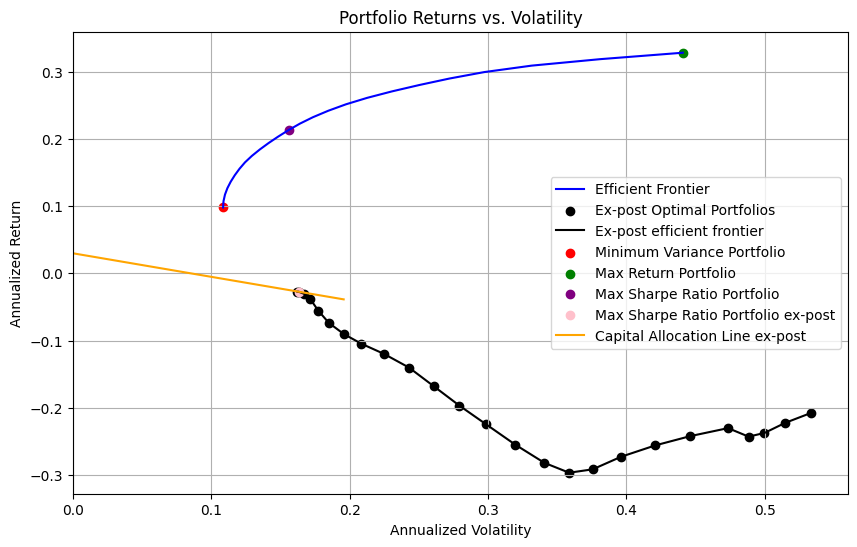

In [1638]:
#Find the index of the maximum value in the 'Ex-post Sharpe Ratio' column of the dataFrame
max_sharpe_index_expost = df_portfolio_22['Ex-post Sharpe Ratio'].idxmax()

#Get the ex-post volatility and the ex-post return of the maximum ex-post sharpe ratio portfolio
max_sharpe_volatility_expost = df_portfolio_22.loc[max_sharpe_index_expost, 'Ex-post Annualized Volatility']
max_sharpe_return_expost = df_portfolio_22.loc[max_sharpe_index_expost, 'Ex-post Annualized Returns']

#Define the boundaries of the ex-post CAL
CAL_x_expost = max_sharpe_volatility_expost * 1.2
CAL_y_expost = rfr_expected + (cal_x_end_expost * (max_sharpe_return_expost - rfr_expected) / max_sharpe_volatility_expost)

#Plot the figure
#Initialize the figure
plt.figure(figsize=(10, 6))

#Plot the efficient frontier ex-ante
#plt.scatter(df_frontier_high['Annualized Volatility'], df_frontier_high['Annualized Return'], color='blue', label='Optimal Portfolios')
plt.plot(df_frontier_high['Annualized Volatility'], df_frontier_high['Annualized Return'], color='blue', label='Efficient Frontier')

#Plot the efficient frontier ex-post
plt.scatter(df_portfolio_22['Ex-post Annualized Volatility'], df_portfolio_22['Ex-post Annualized Returns'], color='black', label='Ex-post Optimal Portfolios')
plt.plot(df_portfolio_22['Ex-post Annualized Volatility'], df_portfolio_22['Ex-post Annualized Returns'], color='black', label='Ex-post efficient frontier')

#Plot the MVP, MaxRP, Max Sharpe Ratio Portfolio (ex-ante), Max Sharpe Ratio Portfolio ex-post
plt.scatter(df_frontier_high.loc[MVP_index, 'Annualized Volatility'], df_frontier_high.loc[MVP_index, 'Annualized Return'], color='red', label='Minimum Variance Portfolio')
plt.scatter(df_frontier_high.loc[MaxRP_index, 'Annualized Volatility'], df_frontier_high.loc[MaxRP_index, 'Annualized Return'], color='green', label='Max Return Portfolio')
plt.scatter(df_frontier_high.loc[max_sharpe_index, 'Annualized Volatility'], df_frontier_high.loc[max_sharpe_index, 'Annualized Return'], color='purple', label='Max Sharpe Ratio Portfolio')
plt.scatter(max_sharpe_volatility_expost, max_sharpe_return_expost, color='pink', label='Max Sharpe Ratio Portfolio ex-post')

#Plot the ex-post CAL
plt.plot([0, CAL_x_expost], [rfr_expected, CAL_y_expost], color='orange', label='Capital Allocation Line ex-post')

#Add title, legends, ect
plt.xlim(0)
plt.title('Portfolio Returns vs. Volatility')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.legend()
plt.grid(True)
plt.show()

- Which portfolio had the
highest performance in terms of ex-ante Sharpe ratio? 
- Which portfolio has produced
the highest performance in terms of ex-post Sharpe ratio?
- Compare and comment the performance of the equally-weighted, value-weighted, and
efficient portfolios over the same sample period. 
(memo for me and giulia)